In [111]:
import os
from essentia import *
from essentia.standard import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import get_window
import mir_eval
import requests
import zipfile


Unzipping dataset...
Processing dataset...
Comparing file: train07REF.txt
--> Non Normalized
Voicing Recall 	 0.980198019802
Voicing False Alarm 	 0.995321637427
Raw Pitch Accuracy 	 0.0366919044846
Raw Chroma Accuracy 	 0.0972626674432
Overall Accuracy 	 0.0260497667185
--> Normalized
Voicing Recall 	 0.952242283052
Voicing False Alarm 	 0.947368421053
Raw Pitch Accuracy 	 0.0955154338963
Raw Chroma Accuracy 	 0.100174723355
Overall Accuracy 	 0.0812597200622
-----------------------------------

Comparing file: train05REF.txt
--> Non Normalized
Voicing Recall 	 0.333333333333
Voicing False Alarm 	 0.376162299239
Raw Pitch Accuracy 	 0.0226283724978
Raw Chroma Accuracy 	 0.0787641427328
Overall Accuracy 	 0.226946279805
--> Normalized
Voicing Recall 	 0.932114882507
Voicing False Alarm 	 0.913778529163
Raw Pitch Accuracy 	 0.0691906005222
Raw Chroma Accuracy 	 0.0700609225413
Overall Accuracy 	 0.0749784544671
-----------------------------------

Comparing file: train09REF.txt
--> Non 

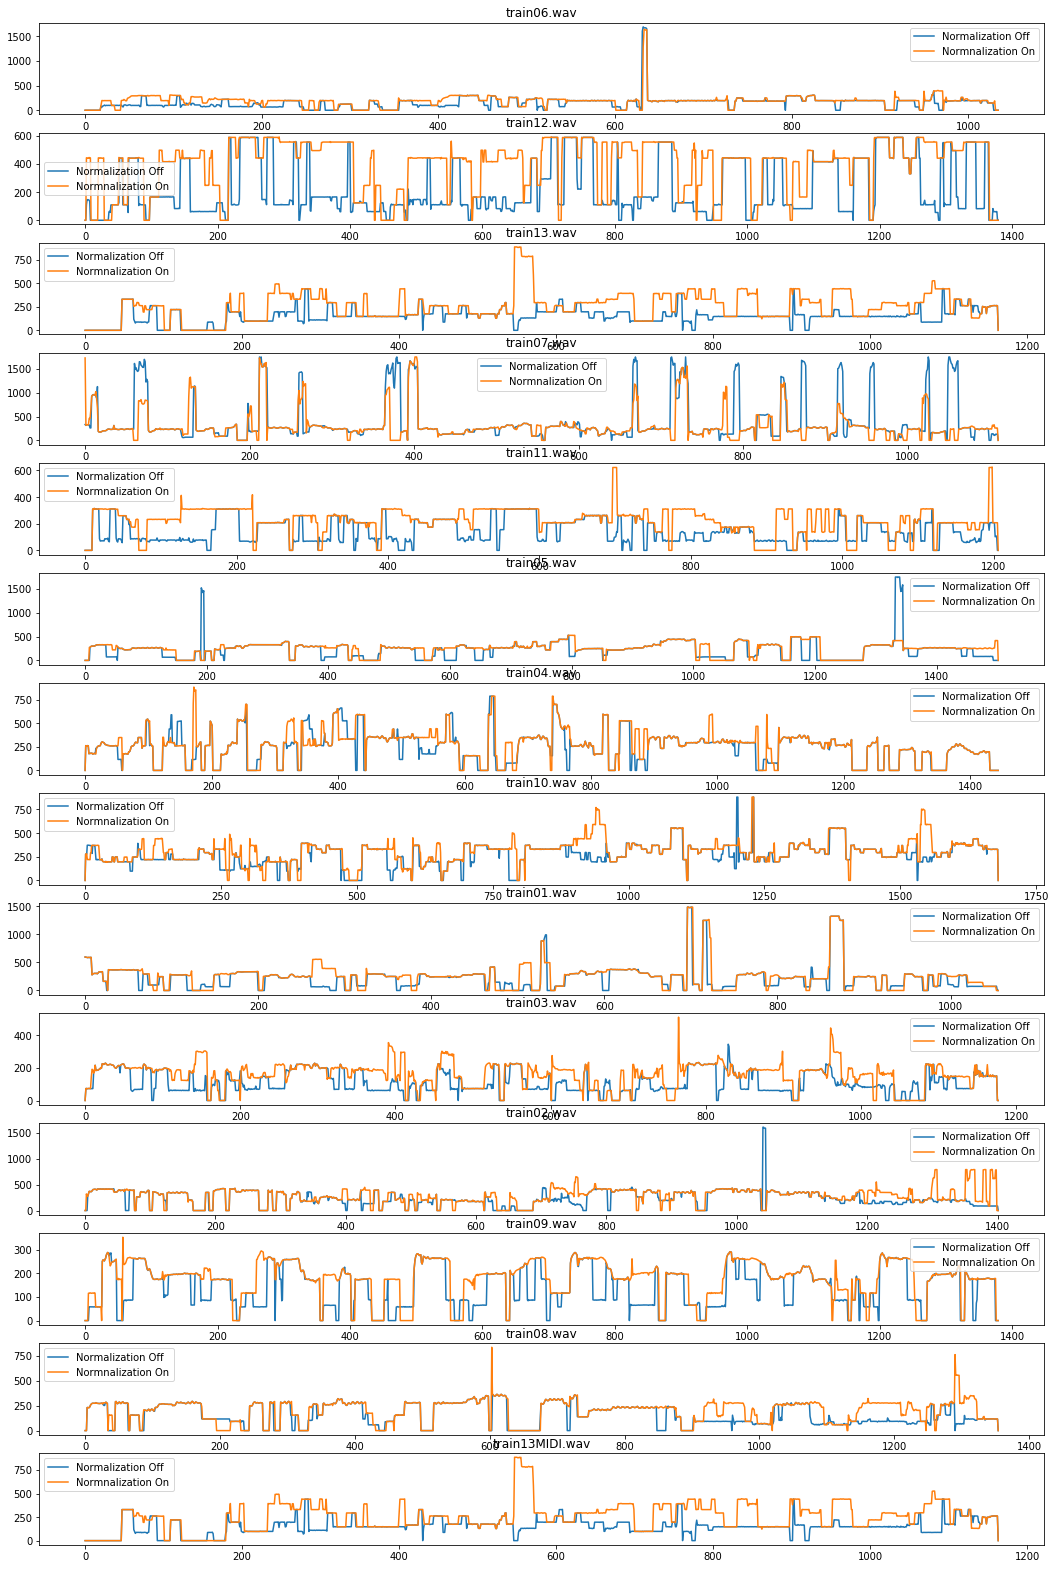

In [117]:

# Initializations
soundsDir = './mirex05TrainFiles/'
fs = 44100
windowSize=2048
hopSize=1024
run_predominant_melody = PitchMelodia(guessUnvoiced=True,
                                      frameSize=windowSize,
                                      hopSize=hopSize,
                                      maxFrequency=2000,
                                      minFrequency=50,
                                      sampleRate=fs);
files = os.listdir(soundsDir)

# Delete files from past runs, if exist
try:
    os.remove('./mirex05TrainFiles.zip')
except OSError:
    pass

try:
    os.remove(soundsDir)
except OSError:
    pass

wavFiles = []
for fileName in files:
    if fileName.endswith("_NormOff.txt") or fileName.endswith("_NormOn.txt"):
        try:
            os.remove(os.path.join('.', fileName))
        except OSError:
            pass
        
os.rename(os.path.join(soundsDir, 'train13MIDI.wav'), os.path.join(soundsDir, 'train13.wav')) 
        
# Download Dataset
print('Downloading dataset...')
url = 'https://labrosa.ee.columbia.edu/projects/melody/mirex05TrainFiles.zip'  
r = requests.get(url)
with open('./mirex05TrainFiles.zip', 'wb') as f:  
    f.write(r.content)

# Unzip Dataset
print('Unzipping dataset...')
zip = zipfile.ZipFile('mirex05TrainFiles.zip')  
zip.extractall('.')  

print('Processing dataset...')


# Find .wav files in the folder

files = os.listdir(soundsDir)
wavFiles = []
for fileName in files:
    if not fileName.startswith('.') and fileName.endswith(".wav"):
        wavFiles.append(fileName)
        
# Configure plot area
numFrm2plot=len(wavFiles)
plt.figure(figsize=(18, numFrm2plot*2))
plotInd=1

# For each file...
for fileName in wavFiles:
    fileNameP = os.path.join(soundsDir, fileName)
    
    # Create normalized (x2) and non normalized (x2) pitch analysis
    x1 = MonoLoader(filename = fileNameP, sampleRate=fs)()
    x2 = EqualLoudness()(x1)
    
    # Create non normalized analysis and saving to a file
    run_predominant_melody = PitchMelodia(guessUnvoiced=True,frameSize=int(windowSize),hopSize=hopSize,sampleRate=fs);
    f01, confidence = run_predominant_melody(x1)
    startIndexes=np.arange(0, x1.size-windowSize,hopSize, dtype=int)
    with open(soundsDir+fileName[:-4]+'_NormOff.txt', 'w') as f:
        for k in range(startIndexes.size):
            f.write(str(k*0.01)+'\t'+str(f01[k])+'\n')
    
    # Create normalized analysis and saving to a file
    run_predominant_melody = PitchMelodia(guessUnvoiced=True,frameSize=int(windowSize),hopSize=hopSize,sampleRate=fs);
    f02, confidence = run_predominant_melody(x2)
    startIndexes=np.arange(0, x1.size-windowSize,hopSize, dtype=int)
    with open(soundsDir+fileName[:-4]+'_NormOn.txt', 'w') as f:
        for k in range(startIndexes.size):
            f.write(str(k*0.01)+'\t'+str(f02[k])+'\n')
    
    # Plot comparisons between normalized and non normalized
    plt.subplot(numFrm2plot, 1, plotInd)
    plt.plot(f01)
    plt.plot(f02)
    plt.title(fileName)
    plt.legend(['Normalization Off', 'Normnalization On'])
    plotInd+=1 
    
# Comparing ground truth with results...

anFiles = []
for fileName in files:
    if not fileName.startswith('.') and fileName.endswith("REF.txt"):
        anFiles.append(fileName)
            
# For each file...
for fileName in anFiles:
    fileNameP = os.path.join(soundsDir, fileName)
        
    print ('Comparing file: ' + fileName)
        
    # Read provided analysis from dataset
    ref_time, ref_freq = mir_eval.io.load_time_series(os.path.join(soundsDir, fileName))
        
    ##### Comparison with NON Normalized #####

    #Re-reading Essentia estimation results
    est_time, est_freq = mir_eval.io.load_time_series(os.path.join(soundsDir, fileName[:-7])+'_NormOff.txt')

    #Running evaluation and printing
    scores = mir_eval.melody.evaluate(ref_time, ref_freq,est_time, est_freq)
    print ('--> Non Normalized')
    for score in scores:
        print(score,'\t',scores[score])
        
    ##### Comparison with Normalized #####

    #Re-reading Essentia estimation results
    est_time, est_freq = mir_eval.io.load_time_series(os.path.join(soundsDir, fileName[:-7])+'_NormOn.txt')

    #Running evaluation and printing
    scores = mir_eval.melody.evaluate(ref_time, ref_freq,est_time, est_freq)
    print ('--> Normalized')
    for score in scores:
        print(score,'\t',scores[score])
        
    print ('-----------------------------------\n')

